# Simple Regression Model for all links
This model will predict the values for N_time(time in the network). For N_time prediction, a linear regresion over size/rate is done. Rate information is fetched from fts_aggragated_* index which was previously populated with rate per link per minute.
* import libraries
* create the RSE to site mapping
* get the data
* fit the model
* TODO: test against the data over the next week
* plot plot plot

In [5]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from scipy.optimize import leastsq,fmin_slsqp, least_squares

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

#### Get AGIS endpoints (RSEs) and site names

In [ ]:
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Reading fts data for one day - all links

In [ ]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-04-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([r['src_rse'],r['dst_rse'],rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['SRC','DST','LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']

['fts_2017-03-31', 'fts_2017-04-01', 'fts_2017-04-02', 'fts_2017-04-03', 'fts_2017-04-04', 'fts_2017-04-05', 'fts_2017-04-06', 'fts_2017-04-07', 'fts_2017-04-08']
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
22000000
23000000
24000000
25000000
Reading took 3005.4382576942444 seconds.


In [6]:
#get all the links

links = []
for row in data.itertuples():
    if row.LINK not in links:
        links.append(row.LINK)
print(len(links))

9572


# Non Linear Fit
rate[bytes/s] = size[bytes] / ( size [bytes]/constant1[bytes/s] + constant2[s]) limited to constant3[bytes/s]

LOAD MODEL

In [187]:
links_stats = pickle.load(open('net_models-20170401-07.pickle','rb'))
links_stats2 = pickle.load(open('net_models-20170401-07-v2.pickle','rb'))

In [ ]:
print(len(links_stats))
i = 0.
for link in links_stats:
    if link[3] < 100:
        #print(link)
        i += 1
print(i,i*100/len(links_stats))

In [ ]:
link = 'CERN-PROD__BNL-ATLAS'
cut = data.where(data.LINK == link).dropna()
rate = model[model.LINK == link].RATE.values[0]
overhead = model[model.LINK == link].OVERHEAD.values[0]
diskrw = model[model.LINK == link].DISKRW.values[0]

In [188]:
model = pd.DataFrame(links_stats, columns=['LINK','R2','RMSE','DATALEN','RATE','OVERHEAD','DISKRW'])
model2 = pd.DataFrame(links_stats2, columns=['LINK','R2','RMSE','DATALEN','RATE','OVERHEAD','DISKRW'])

In [ ]:
cut['N_PRED'] = cut.SIZE/((cut.SIZE/rate)+overhead)
cut['N_PRED'][cut['N_PRED']>diskrw]=diskrw

In [ ]:
plt.plot(cut.SIZE,cut.N_RATE,'.')
plt.plot(cut.SIZE,cut.N_PRED,'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Size in Bytes')
plt.ylabel('Rate in B/s')
plt.title('Network rate for %s'%link.replace('__','-->'))
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
#print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
plt.show()

In [11]:
def objective(vars, x, data):
    rate = vars[0]
    overhead = vars[1]
    diskrw_limit = vars[2]
    model = x/((x/rate)+overhead)
    model[model>float(diskrw_limit)] = diskrw_limit
    return data - model
    

In [13]:
def test_model(link, data, model=model, overh_init=0.1, diskrw_init=100., show=False):
    cut = data.where(data.LINK == link).dropna()
    cut.N_RATE[cut.N_RATE == np.inf] = np.nan
    cut = cut.dropna()
    #cut = cut.where(cut.SIZE > 0).dropna()
    #cut = cut.where(cut.N_RATE > 0).dropna()
    if link not in model.LINK.values:
        print('WARNING: no model found for', link,maxindex)
        cut['N_PRED'] = [-np.inf]*len(cut)
    else:
        rate = model[model.LINK == link].RATE.values[0]
        overhead = model[model.LINK == link].OVERHEAD.values[0]
        diskrw = model[model.LINK == link].DISKRW.values[0]
        cut['N_PRED'] = cut.SIZE/((cut.SIZE/rate)+overhead)
        cut['N_PRED'][cut['N_PRED']>diskrw]=diskrw
    
    #vars = [cut.N_RATE.mean(), overh_init, diskrw_init]
    #vars = [cut.N_RATE.mean(), 0.1, 100.]
    #out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
    #out = leastsq(objective, vars, args=(cut.SIZE, cut.N_RATE))
    #rate = out.x[0]
    #overhead = out.x[1]
    #diskrw = out.x[2] 
    #print(link,out)
    #cut['N_PRED2'] = cut.SIZE/((cut.SIZE/rate)+overhead)
    #cut['N_PRED2'][cut['N_PRED2']>diskrw]=diskrw
    try:
        r2score = r2(cut.N_RATE,cut.N_PRED)
        rmse = np.sqrt(mse(cut.N_RATE,cut.N_PRED))
    except ValueError:
        r2score = -np.Inf
        rmse = np.Inf
    #try:
    #    r2score2 = r2(cut.N_RATE,cut.N_PRED2)
    #    rmse2 = np.sqrt(mse(cut.N_RATE,cut.N_PRED2))
    #except ValueError:
    #    r2score2 = -np.Inf
    #    rmse2 = np.Inf
    datalen = len(cut)
    if show:
        cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
        plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
        plt.plot(cut.SIZE/(1024*1024), cut.N_PRED/(1024*1024),'.', label='pred')
        #plt.plot(cut.SIZE/(1024*1024), cut.N_PRED2/(1024*1024),'.', label='pred new')
        plt.title('NETWORK rates for %s'%link.replace('__', '-->'))
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('Link Rate in MiB/s')
        plt.xlabel('Transfer size MiB')

        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        #print ('RMSE:%.02f R²:%.02f'%(rmse,r2score))
        plt.show()
    return r2score, rmse, datalen, rate, overhead, diskrw#, r2score2, rmse2

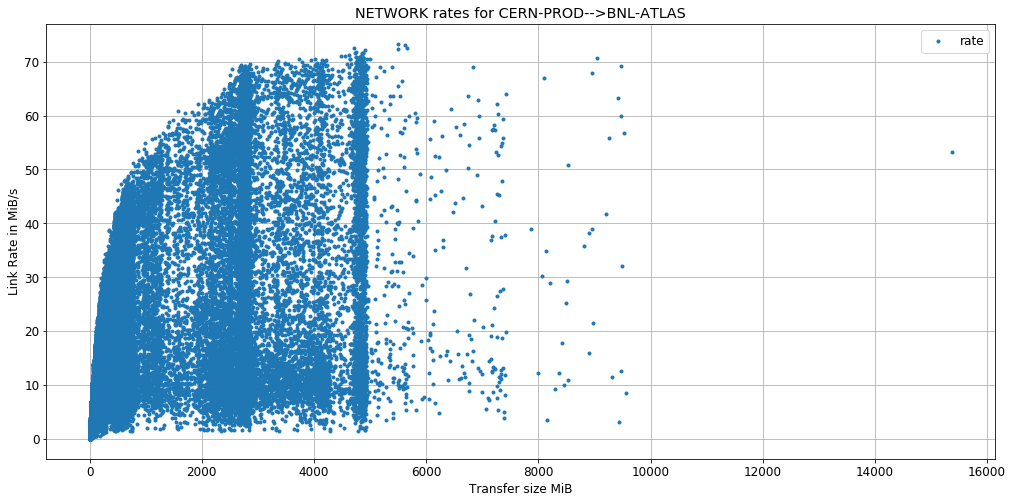

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


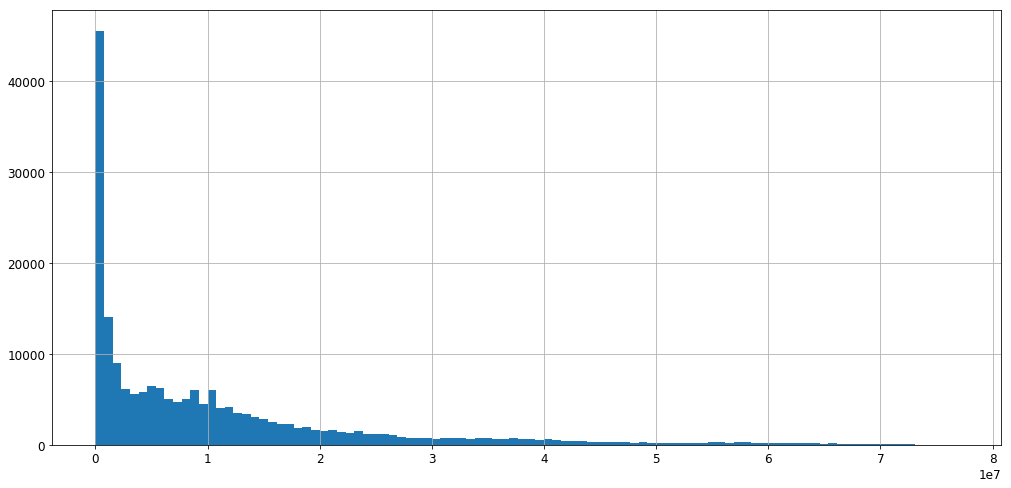

In [139]:
#link = 'BNL-ATLAS__TOKYO-LCG2'
link = 'CERN-PROD__BNL-ATLAS'
#link = 'BNL-ATLAS__CERN-PROD'
#link = 'RAL-LCG2__CSCS-LCG2'
#link = 'FZK-LCG2__SWT2_CPB'
#link = 'SARA-MATRIX__ru-PNPI'
#link = 'BNL-ATLAS__CA-MCGILL-CLUMEQ-T2'
#link = 'Taiwan-LCG2__SiGNET'
#link =  'UNI-FREIBURG__BNL-ATLAS'
#link = 'UKI-SCOTGRID-GLASGOW__Taiwan-LCG2'
#link = 'WT2__BNL-ATLAS'
#link =  'RRC-KI-T1__RAL-LCG2'
#link = 'IFIC-LCG2__INFN-T1'
#link = 'RAL-LCG2__CSCS-LCG2'
cut = data.where(data.LINK == link).dropna()
cut.N_RATE[cut.N_RATE == np.inf] = cut.SIZE
plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
plt.title('NETWORK rates for %s'%link.replace('__', '-->'))
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Link Rate in MiB/s')
plt.xlabel('Transfer size MiB')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()
plt.hist(cut.N_RATE,bins=100)
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

Initialization: overhead=4.866743  diskrw=159.553684


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


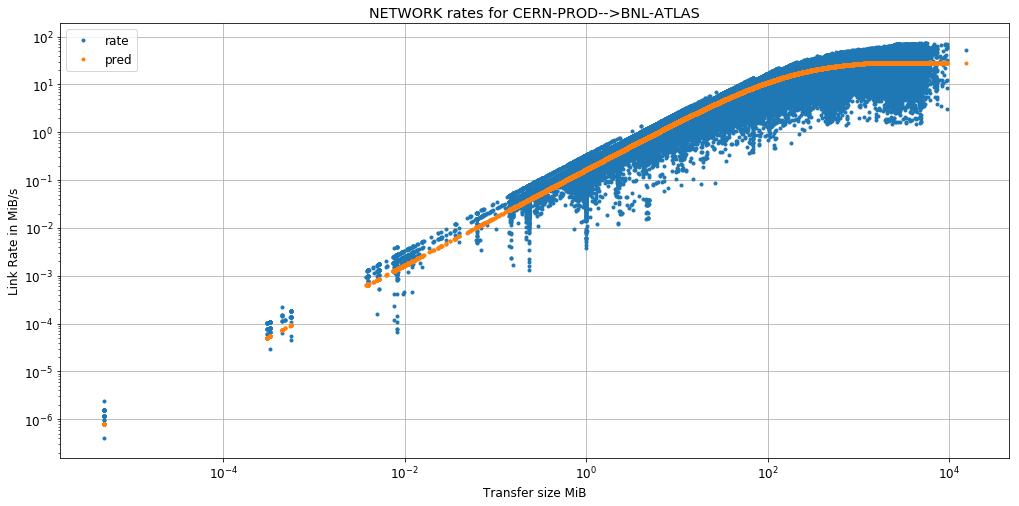

r2:    0.628462591773
rmse:  7.80404592634
rate:  31.9447207287
overh: 5.99242316324
disk:  28.7103166812


In [140]:
#link = 'BNL-ATLAS__TOKYO-LCG2'
first = cut[cut.SIZE < 10**6]
p1 = np.polyfit(first.SIZE, first.N_RATE,1)
p1 = np.poly1d(p1)
secnd = cut[cut.SIZE > 10**7]
p2 = np.polyfit(secnd.SIZE, secnd.N_RATE,1)
p2 = np.poly1d(p2)
oini=max(0.01,1/p1.coeffs[0])
dini=max(0.01,1/p2.coeffs[0])
print('Initialization: overhead=%f  diskrw=%f'%(oini, dini))
r_2,rmse,datalen, rate,over,disk= test_model(link, data,model2,overh_init=oini,diskrw_init=dini, show=True)
print('r2:   ', r_2)
print('rmse: ', rmse/(1024*1024))
print('rate: ', rate/(1024*1024))
print('overh:', over)
print('disk: ', disk/(1024*1024))
#print('r2.2: ', r_22)
#print('rmse2:', rmse2/(1024*1024))

In [141]:
d = {}
for v in cut.itertuples():
    if v.SRC+'__'+v.DST not in d.keys():
        d[v.SRC+'__'+v.DST] = []
    d[v.SRC+'__'+v.DST].append([v.SIZE, v.N_RATE])

for k in d:
    d[k] = np.array(d[k]).T


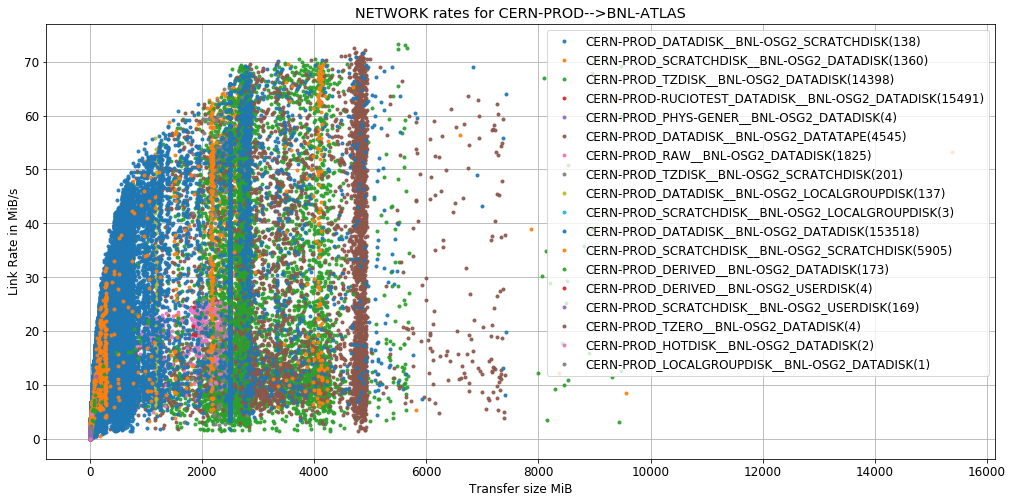

In [143]:
for k in d:
    plt.plot(d[k][0]/(1024*1024), d[k][1]/(1024*1024),'.', label=(k+'('+str(len(d[k][0]))+')'),alpha=0.9)
plt.title('NETWORK rates for %s'%link.replace('__', '-->'))
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Link Rate in MiB/s')
plt.xlabel('Transfer size MiB')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [128]:
for k in d:
    x = '%0.2f, %0.2f, %d, %s' %(d[k][1].mean()/(1024*1024),d[k][1].std()/(1024*1024), len(d[k][0]), k)
    print (x)

4.17, 1.48, 12, BNL-OSG2_DET-SLHC__TOKYO-LCG2_DATADISK
7.00, 5.82, 2, BNL-OSG2_USERDISK__TOKYO-LCG2_LOCALGROUPDISK
29.59, 5.74, 304, BNL-OSG2_LOCALGROUPDISK__TOKYO-LCG2_DATADISK
35.71, 20.61, 86, BNL-OSG2_MCTAPE__TOKYO-LCG2_DATADISK
7.41, 6.69, 3, BNL-OSG2_SCRATCHDISK__TOKYO-LCG2_LOCALGROUPDISK
21.31, 14.36, 636, BNL-OSG2_SCRATCHDISK__TOKYO-LCG2_SCRATCHDISK
33.56, 18.32, 89, BNL-OSG2_DATATAPE__TOKYO-LCG2_DATADISK
3.98, 10.97, 30492, BNL-OSG2_DATADISK__TOKYO-LCG2_DATADISK
3.63, 11.66, 3677, BNL-OSG2_USERDISK__TOKYO-LCG2_SCRATCHDISK


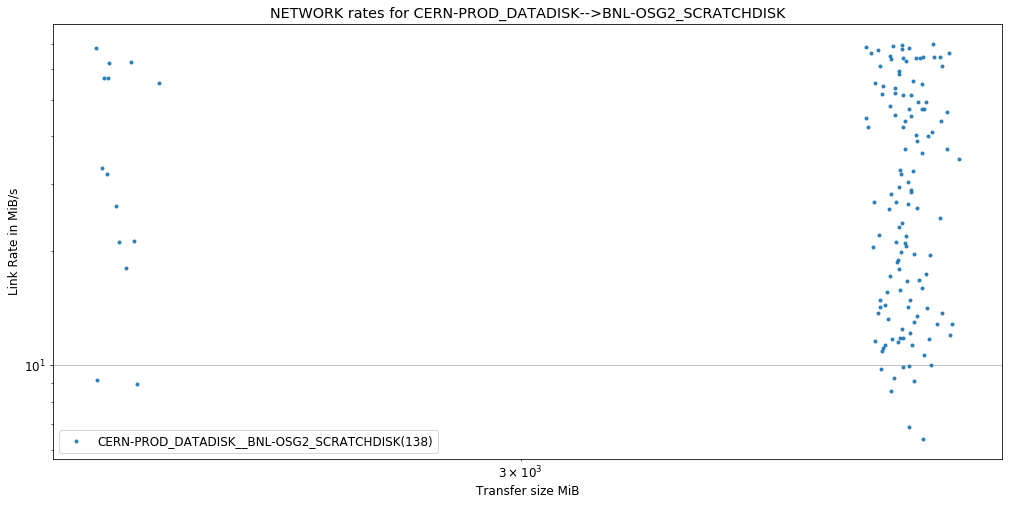

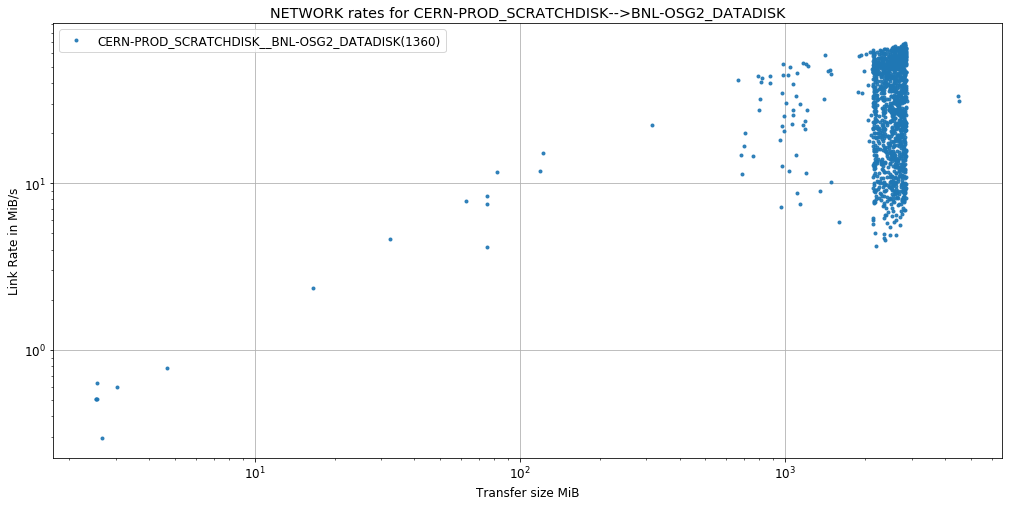

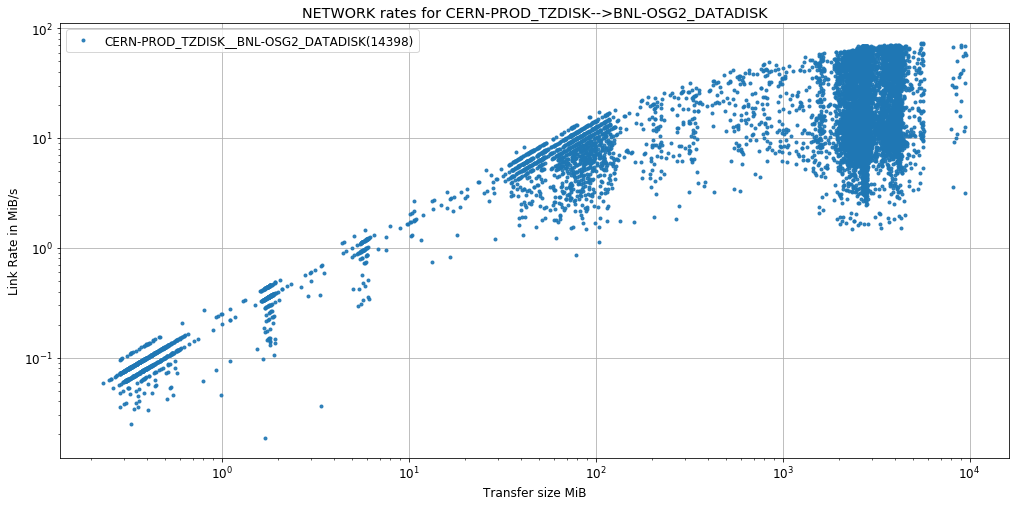

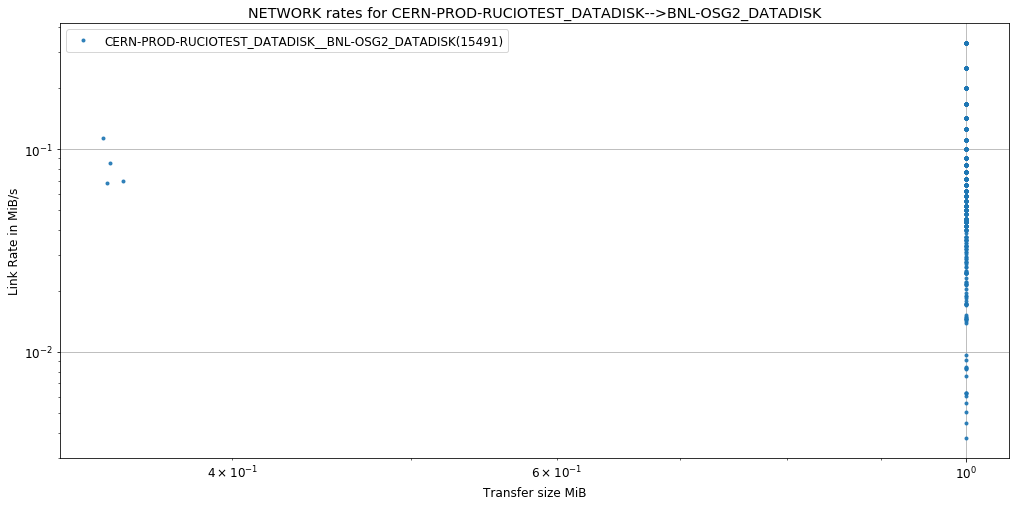

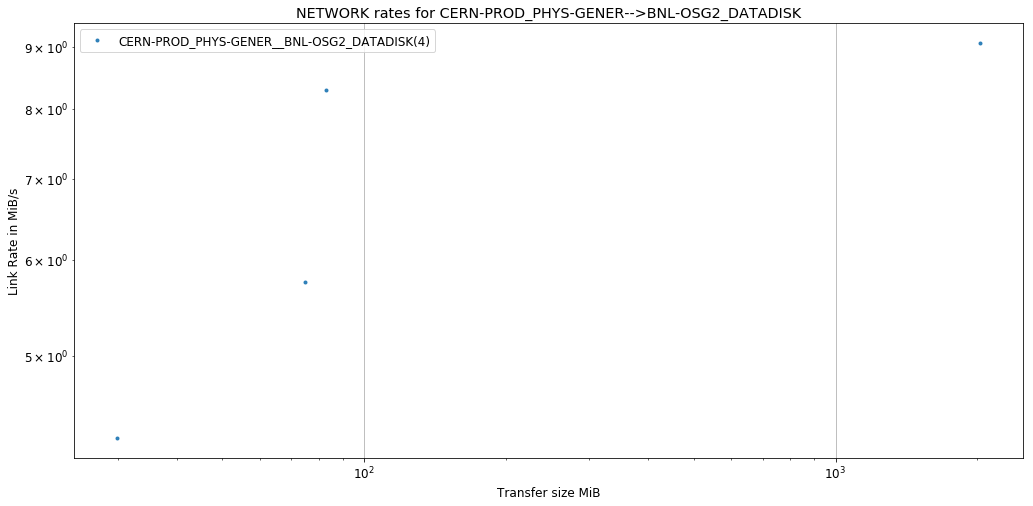

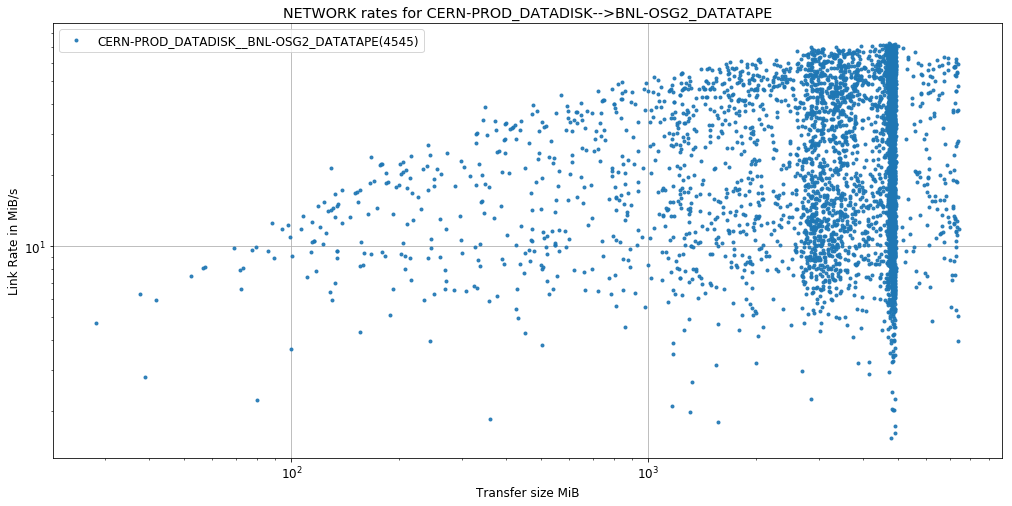

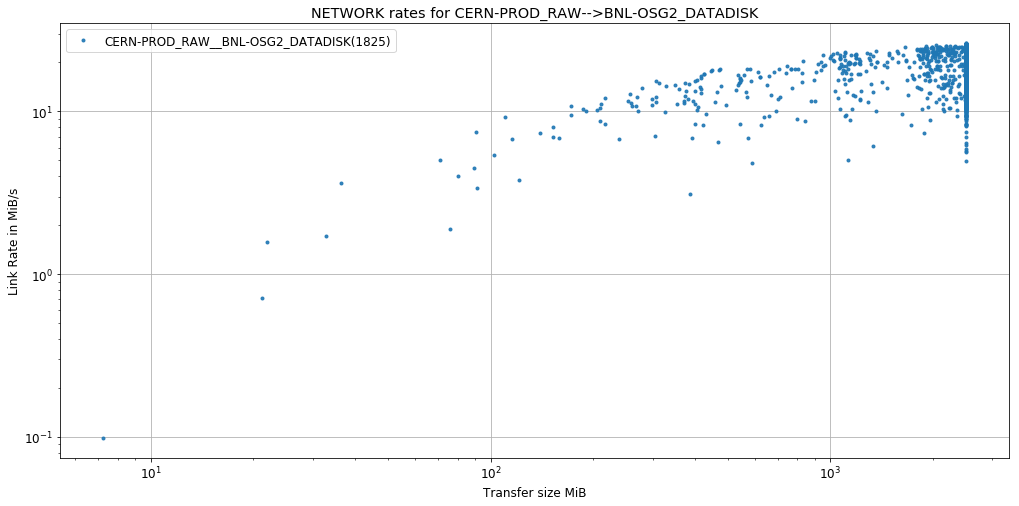

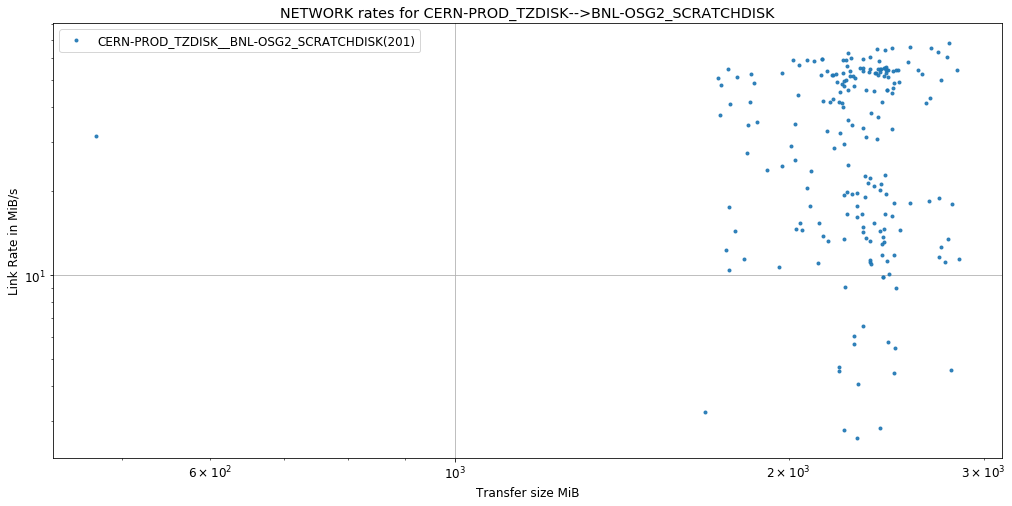

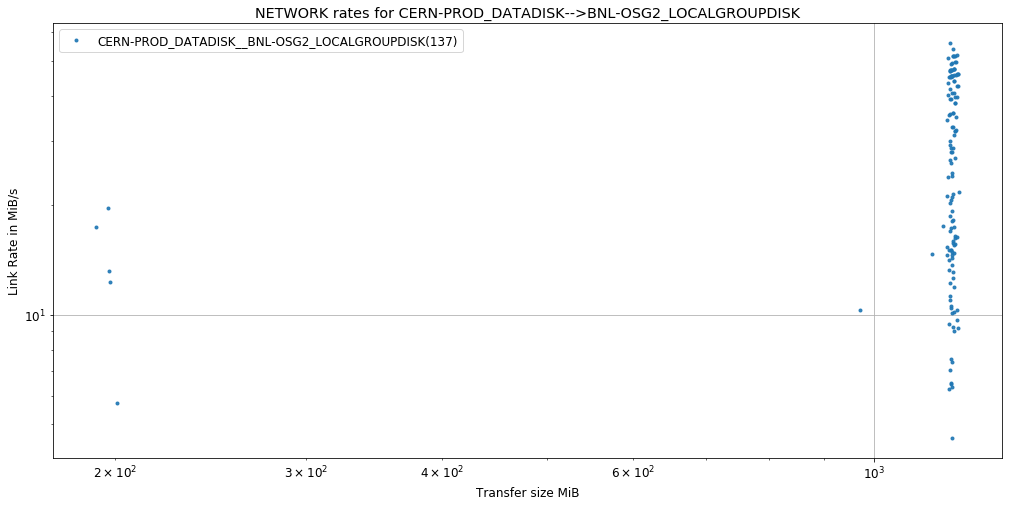

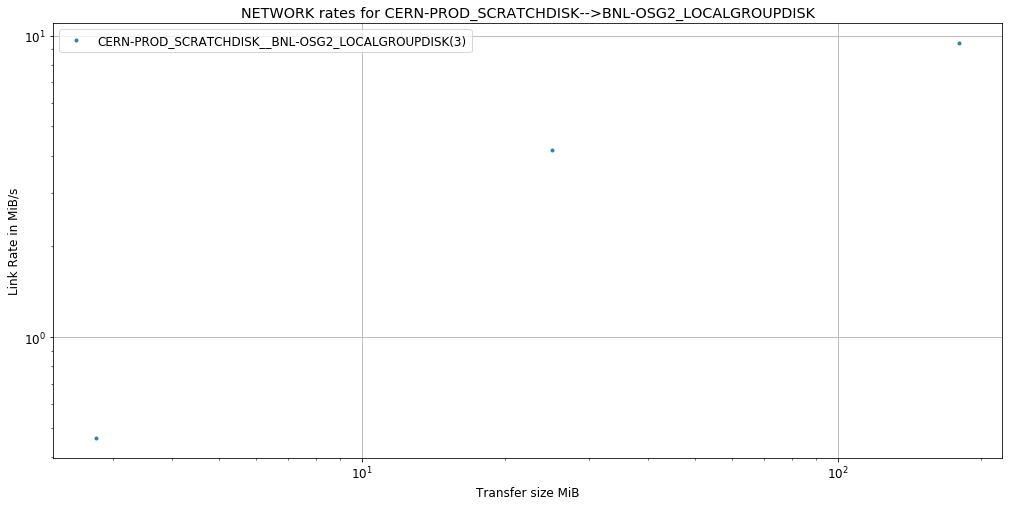

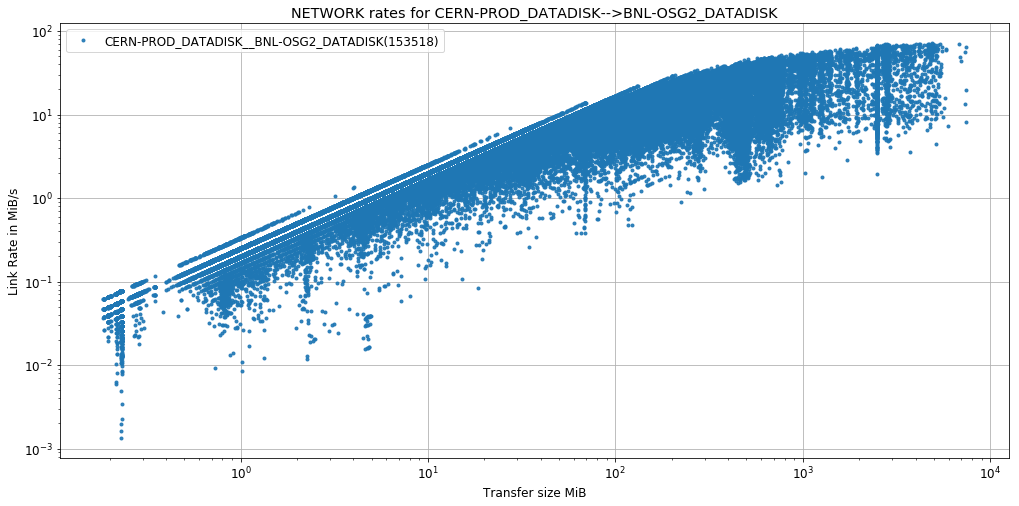

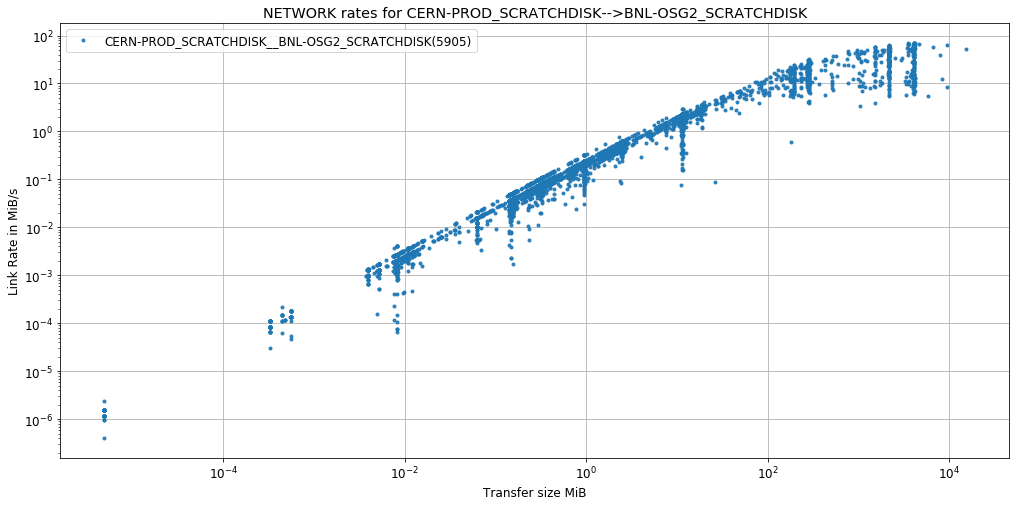

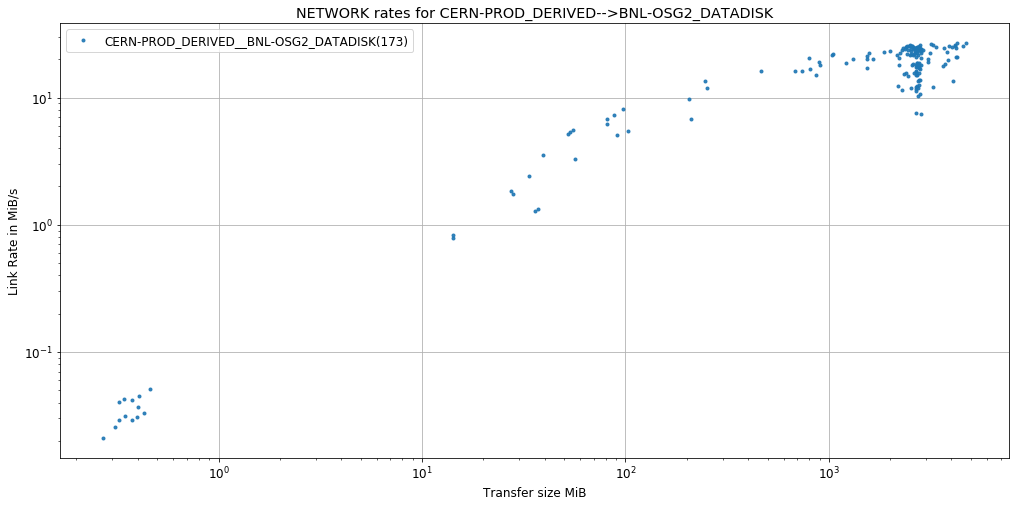

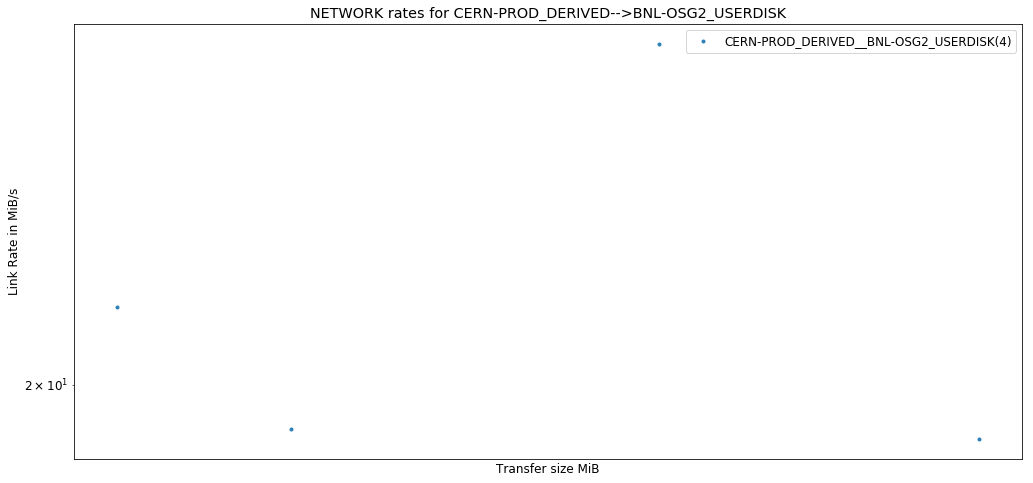

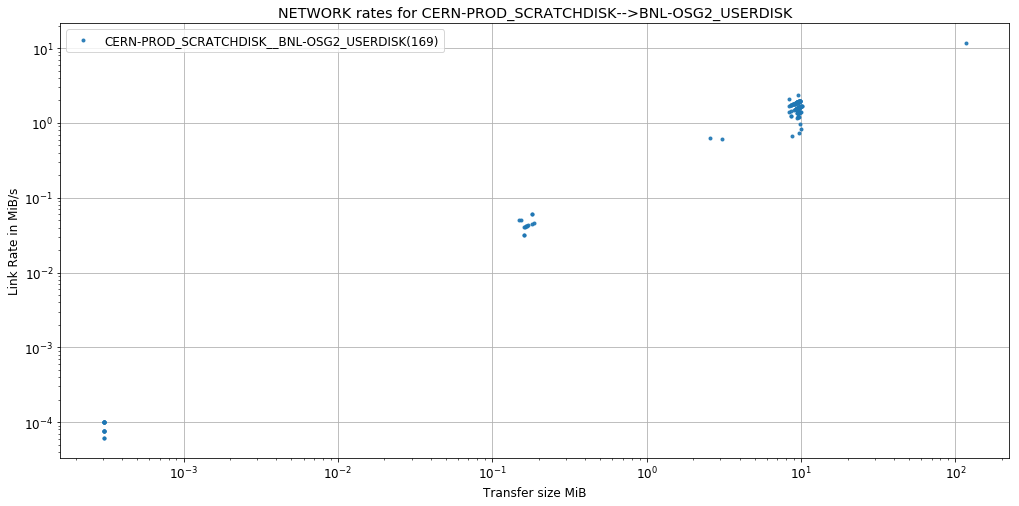

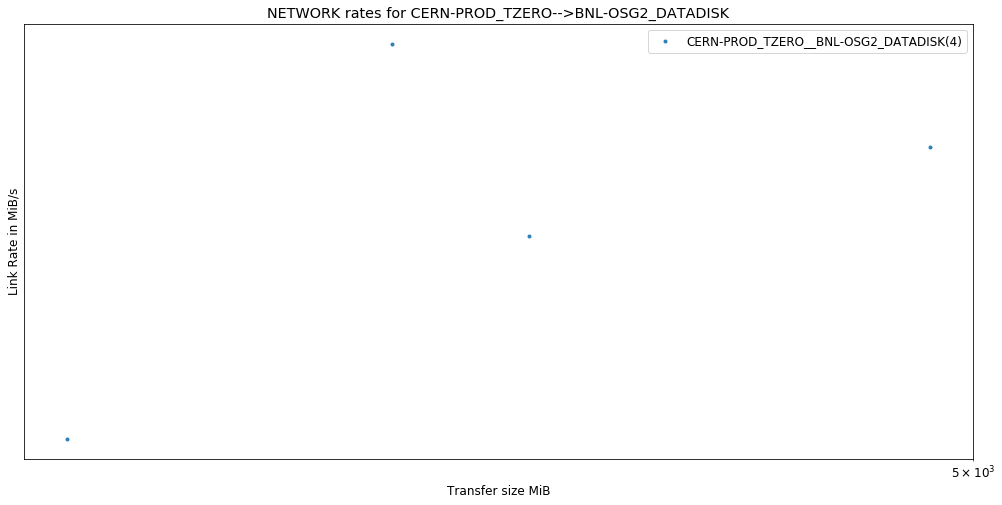

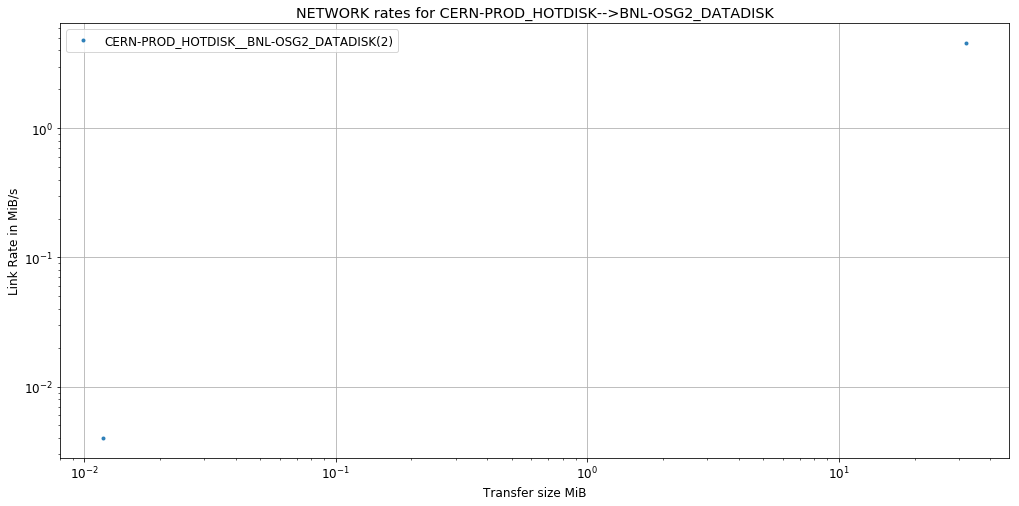

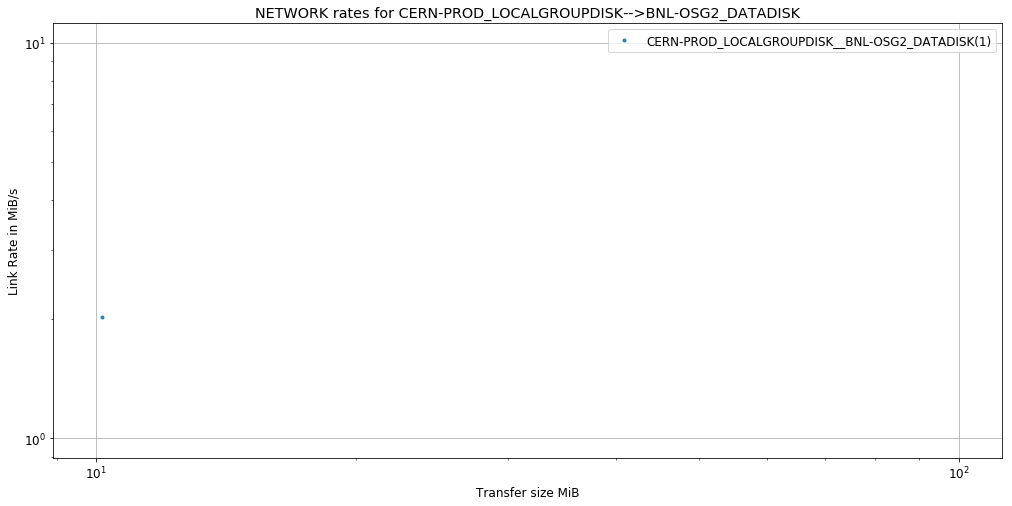

In [123]:
for k in d:
    #plt.hist(d[k][1]/(1024*1024),bins=100, alpha=0.9)
    plt.plot(d[k][0]/(1024*1024), d[k][1]/(1024*1024),'.', label=(k+'('+str(len(d[k][0]))+')'),alpha=0.9)
    plt.title('NETWORK rates for %s'%k.replace('__', '-->'))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Link Rate in MiB/s')
    plt.xlabel('Transfer size MiB')
    fig = plt.gcf()
    fig.set_size_inches(17, 8)
    plt.legend()
    plt.grid()
    plt.show()

In [189]:
model2.corr()

,R2,RMSE,DATALEN,RATE,OVERHEAD,DISKRW
R2,1.000000,-0.330630,-0.004615,0.074201,-0.141814,0.226394
RMSE,-0.330630,1.000000,0.088261,-0.009681,-0.138544,0.534121
DATALEN,-0.004615,0.088261,1.000000,-0.021254,-0.048712,0.133909
RATE,0.074201,-0.009681,-0.021254,1.000000,0.049756,0.127329
OVERHEAD,-0.141814,-0.138544,-0.048712,0.049756,1.000000,-0.104589
DISKRW,0.226394,0.534121,0.133909,0.127329,-0.104589,1.000000


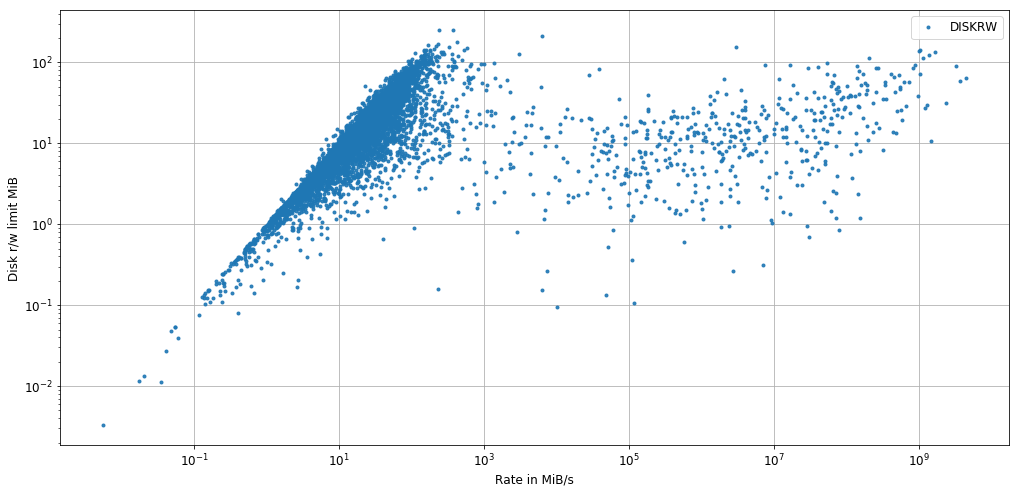

In [192]:
plt.plot(model2.RATE[model2.RATE > -np.inf]/(1024*1024),
         model2.DISKRW[model2.DISKRW > -np.inf]/(1024*1024),
         #model2.OVERHEAD[model2.OVERHEAD > -np.inf],
         '.', alpha=0.9)
#plt.title('NETWORK rates for %s'%k.replace('__', '-->'))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rate in MiB/s')
plt.ylabel('Disk r/w limit MiB')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


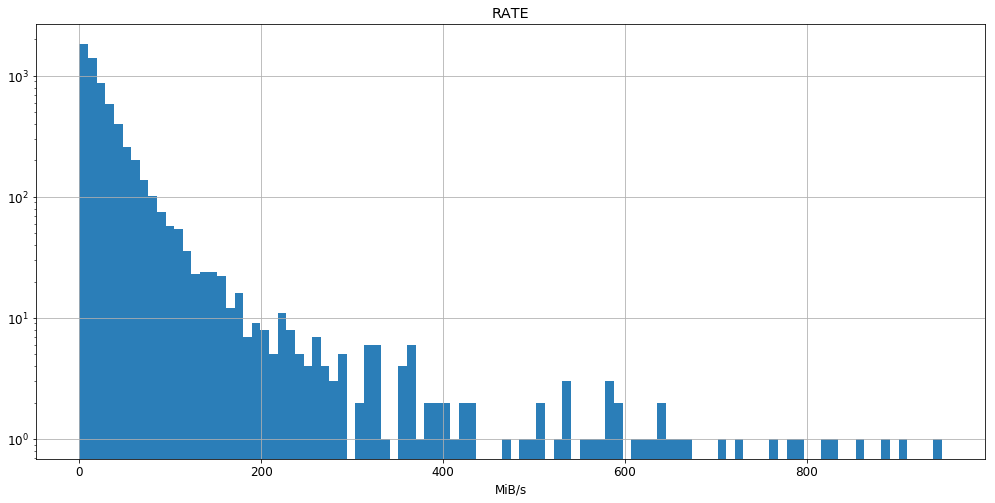

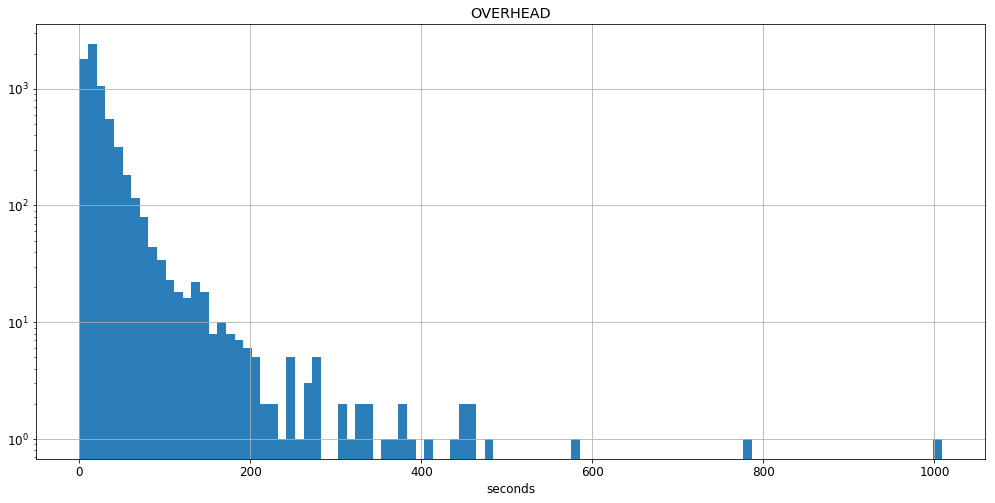

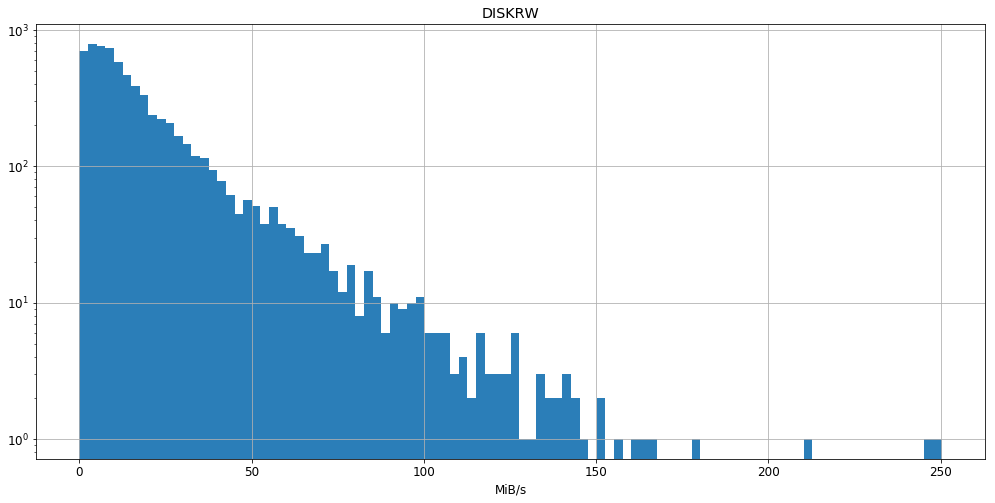

In [198]:
plt.hist(model2.RATE[model2.RATE > -np.inf][model2.RATE < 10**9]/(1024*1024),bins=100, alpha=0.95)
fig = plt.gcf()
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('MiB/s')
#lt.xlim((0,100))
plt.title('RATE')
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(model2.OVERHEAD[model2.OVERHEAD > -np.inf],bins=100, alpha=0.95)
fig = plt.gcf()
#plt.xscale('log')
plt.yscale('log')
plt.title('OVERHEAD')
plt.xlabel('seconds')
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(model2.DISKRW[model2.DISKRW > -np.inf]/(1024*1024),bins=100, alpha=0.95)
fig = plt.gcf()
#plt.xscale('log')
plt.yscale('log')
plt.title('DISKRW')
plt.xlabel('MiB/s')
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()